# IAU Projekt - Fáza 4 - Aktivity na cvičení
Peter Brenkus, Tomáš Brček

Percentuálny podiel: 50/50

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

2024-11-28 09:52:09.204354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 09:52:09.205892: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 09:52:09.208350: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 09:52:09.215619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732783929.227731   29460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732783929.23

In [2]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
BATCH_SIZE = 16

base_path = "data/head_ct"

# 4.1 EDA and data preprocessing

## A

EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu

In [3]:
labels = pd.read_csv("data/labels.csv", index_col="id")

In [4]:
files = sorted(os.listdir(path=base_path))
normal_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 0)]
hemorrhage_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 1)]
print(f'Num. normal: {len(normal_imgs)}, num. hemorrhage: {len(hemorrhage_imgs)}')

Num. normal: 100, num. hemorrhage: 100


Môžeme vidieť, že medzi obrázkami máme 100 takých, ktoré sú normálne a 100 takých, na ktorých je krvácanie. Tieto triedy sme si rozdelili do 2 polí.

### Zobrazenie vzorky

In [5]:
normal_selection = np.random.choice(normal_imgs, 5, replace = False)
hemorrhage_selection = np.random.choice(hemorrhage_imgs, 5, replace = False)

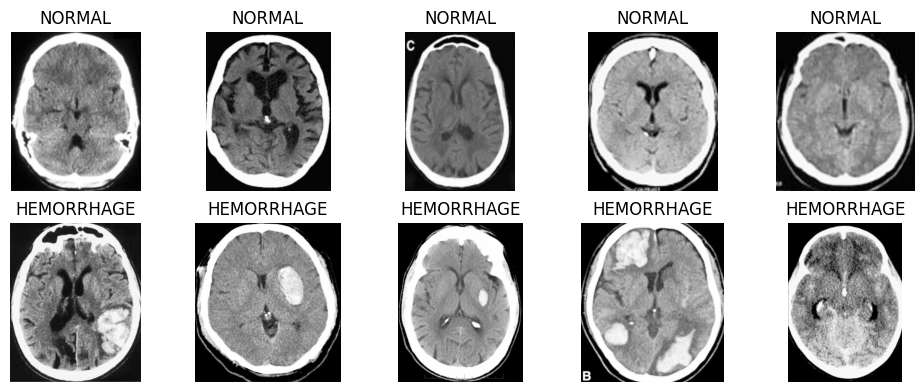

In [6]:
fig = plt.figure(figsize=(12, 12)) 
for i in range(10):
    if i < 5:
        fp = f'data/head_ct/{normal_selection[i]}'
        label = 'NORMAL'
    else:
        fp = f'data/head_ct/{hemorrhage_selection[i-6]}'
        label = 'HEMORRHAGE'
    ax = fig.add_subplot(5, 5, i+1)
    
    fn = image.load_img(fp, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

Vybrali sme vzorku 5 obrázkov z každej triedy, ktoré sme si vykreslili pre lepšiu predstavu.

### Zobrazenie priemerného príkladu

In [7]:
def convert_images_to_matrix(directory, filenames, size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    full_matrix = None
    for filename in filenames:
        file_path = os.path.join(directory, filename)
        loaded_image = image.load_img(file_path, target_size=size, color_mode='grayscale')
        image_array = image.img_to_array(loaded_image).ravel()[np.newaxis, :]
        if full_matrix is None:
            full_matrix = image_array
        else:
            full_matrix = np.vstack((full_matrix, image_array))
    return full_matrix

normal = convert_images_to_matrix('data/head_ct/', normal_imgs)
hemorrhage = convert_images_to_matrix('data/head_ct/', hemorrhage_imgs)

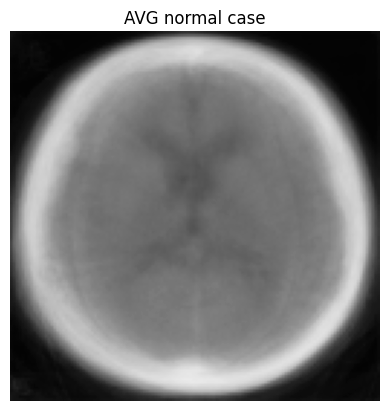

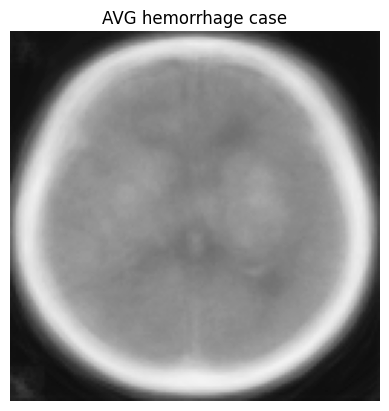

In [8]:
def find_mean_img(full_mat, title, size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean_img = find_mean_img(normal, 'normal')
hemorrhage_mean_img = find_mean_img(hemorrhage, 'hemorrhage')

Na obrázkoch vyššie môžeme vidieť priemerné prípady pre normálne snímky, a pre snímky, ktoré obsahujú krvácanie. 

### Príprava datasetu

In [9]:
def load_image_and_label(image_name, label):
    img_path = tf.strings.join([base_path, image_name], separator="/")
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img, label

In [10]:
normal_labels = [0] * len(normal_imgs)
normal_dataset = tf.data.Dataset.from_tensor_slices((normal_imgs, normal_labels))
normal_dataset = normal_dataset.map(load_image_and_label)

2024-11-28 09:52:11.902503: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
hemorrhage_labels = [1] * len(hemorrhage_imgs)
hemorrhage_dataset = tf.data.Dataset.from_tensor_slices((hemorrhage_imgs, hemorrhage_labels))
hemorrhage_dataset = hemorrhage_dataset.map(load_image_and_label)

In [12]:
full_dataset = normal_dataset.concatenate(hemorrhage_dataset)
full_dataset = full_dataset.shuffle(buffer_size=len(full_dataset))


#### Rozdelenie na trénovacie a testovacie dáta

In [13]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(BATCH_SIZE)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).skip(val_size).batch(BATCH_SIZE)

In [14]:
input_shape = None
for batch, labels in train_dataset.take(1):
    input_shape = batch.shape
    print(input_shape)
    print(labels.numpy())

(16, 128, 128, 3)
[0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1]


2024-11-28 09:52:12.226007: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


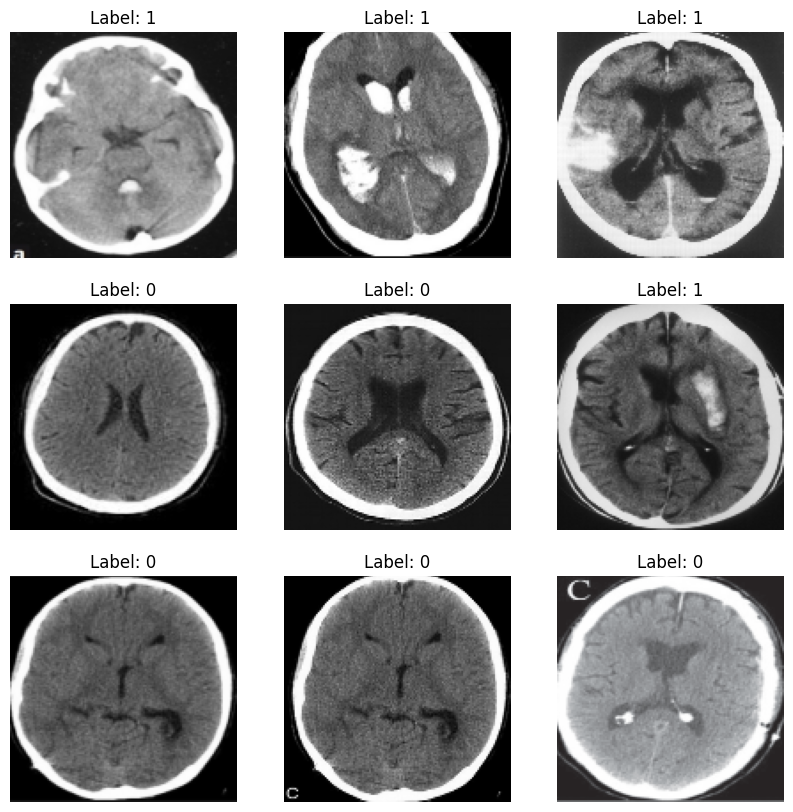

2024-11-28 09:52:12.810103: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
for img, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, img.shape[0])):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i])
        plt.title(f"Label: {label[i].numpy()}")
        plt.axis("off")
    plt.show()

Na obrázkoch vyššie je zobrazený prvý batch pre trénovacie dáta.

## B

Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

# 4.2 Modeling and evaluation

## A

Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model.

In [16]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),  # Normalizácia na [0, 1]
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Pre 2 triedy: sigmoid a jedna výstupná jednotka
])

/mnt/1847ADF2212734FB/vysoka_skola/3_rocnik/1_semester/IAU/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5219 - loss: 0.7347 - val_accuracy: 0.5250 - val_loss: 0.6927
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4592 - loss: 0.6943 - val_accuracy: 0.4500 - val_loss: 0.6948
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4967 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6922
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5285 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5299 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6952
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5089 - loss: 0.6931 - val_accuracy: 0.6750 - val_loss: 0.6837
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5358 - loss: 0.6918 - val_accuracy: 0.5500 - val_loss: 0.6897
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5205 - loss: 0.6923 - val_accuracy: 0.4750 - val_loss: 0.6973


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)
test_acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5333 - loss: 0.6922  


0.550000011920929

In [20]:
train_loss, train_acc = model.evaluate(train_dataset)
train_acc

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4964 - loss: 0.6934


0.5

## B

Zhodnotíte Váš prístup a získaný výsledok